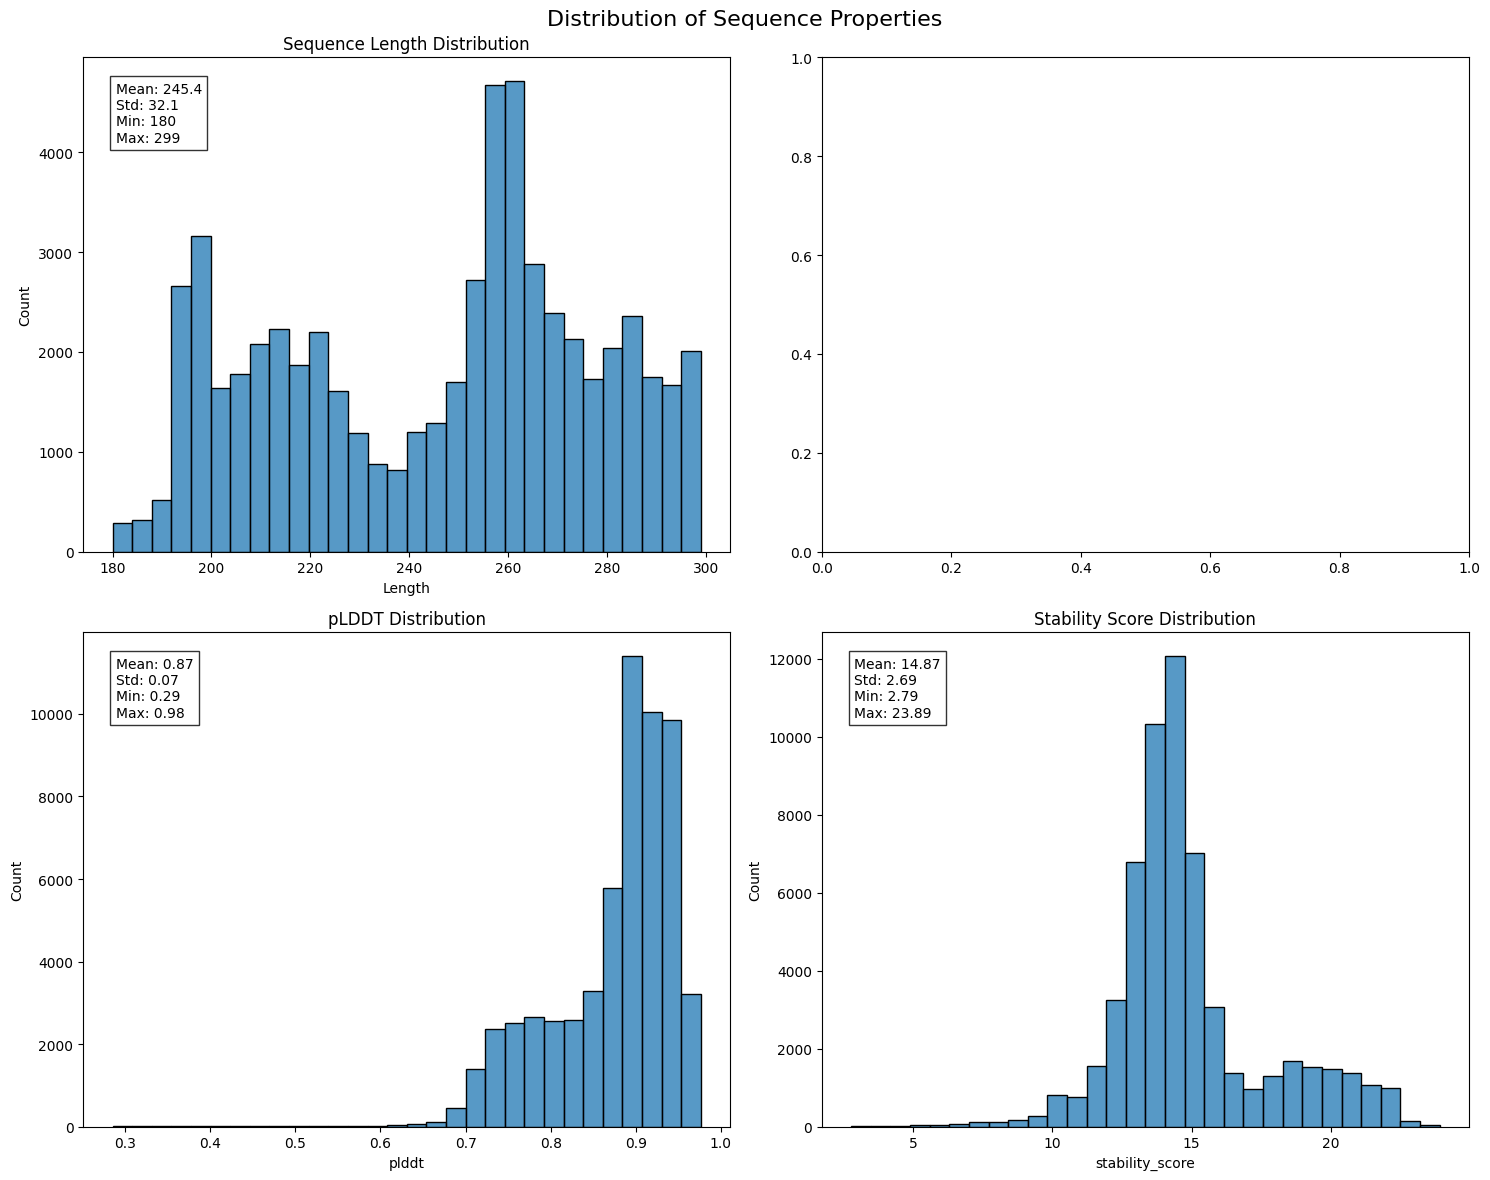


Stability Label Distribution:
stability_label
low    58485
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('brenda/sequences.csv')

# Set up the figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Sequence Properties', fontsize=16)

# Plot sequence length distribution
sns.histplot(data=df, x='length', ax=axes[0,0], bins=30)
axes[0,0].set_title('Sequence Length Distribution')
axes[0,0].set_xlabel('Length')
axes[0,0].text(0.05, 0.95, 
               f"Mean: {df['length'].mean():.1f}\n"
               f"Std: {df['length'].std():.1f}\n"
               f"Min: {df['length'].min()}\n"
               f"Max: {df['length'].max()}",
               transform=axes[0,0].transAxes,
               bbox=dict(facecolor='white', alpha=0.8),
               verticalalignment='top')

# Plot pLDDT distribution
sns.histplot(data=df, x='plddt', ax=axes[1,0], bins=30)
axes[1,0].set_title('pLDDT Distribution')
axes[1,0].text(0.05, 0.95,
               f"Mean: {df['plddt'].mean():.2f}\n"
               f"Std: {df['plddt'].std():.2f}\n"
               f"Min: {df['plddt'].min():.2f}\n"
               f"Max: {df['plddt'].max():.2f}",
               transform=axes[1,0].transAxes,
               bbox=dict(facecolor='white', alpha=0.8),
               verticalalignment='top')

# Plot stability score distribution
sns.histplot(data=df, x='stability_score', ax=axes[1,1], bins=30)
axes[1,1].set_title('Stability Score Distribution')
axes[1,1].text(0.05, 0.95,
               f"Mean: {df['stability_score'].mean():.2f}\n"
               f"Std: {df['stability_score'].std():.2f}\n"
               f"Min: {df['stability_score'].min():.2f}\n"
               f"Max: {df['stability_score'].max():.2f}",
               transform=axes[1,1].transAxes,
               bbox=dict(facecolor='white', alpha=0.8),
               verticalalignment='top')

plt.tight_layout()
plt.show()

# Print additional statistics
print("\nStability Label Distribution:")
print(df['stability_label'].value_counts())


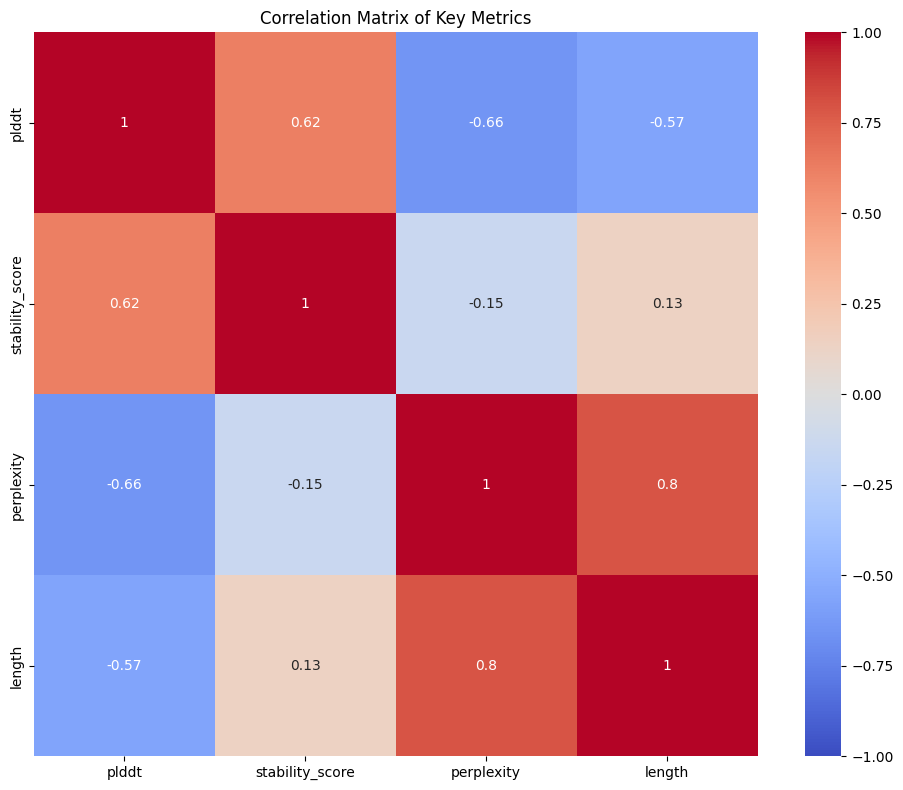

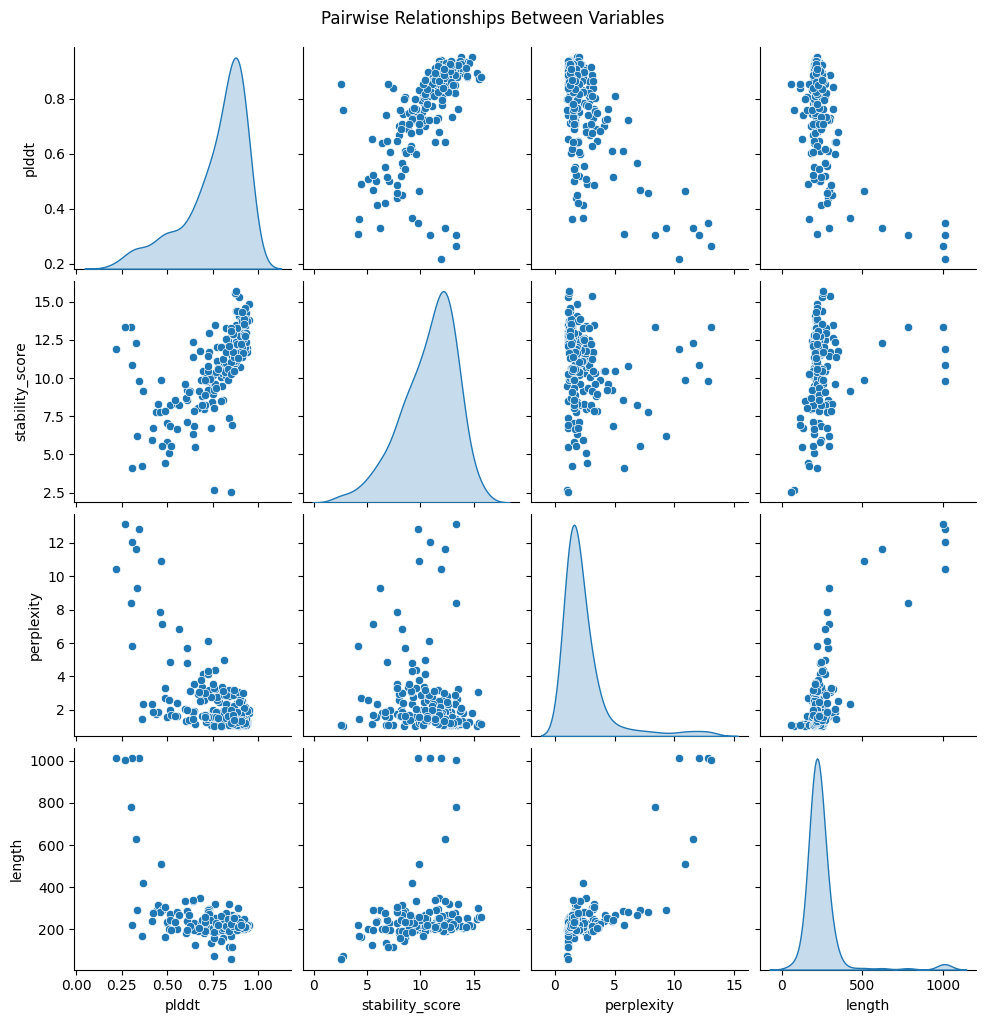

In [7]:
# Add sequence length column
df['length'] = df['sequence'].str.len()

# Create correlation matrix
corr_vars = ['plddt', 'stability_score', 'perplexity', 'length']
corr_matrix = df[corr_vars].corr()

# Create correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, 
            annot=True, # Show correlation values
            cmap='coolwarm', # Red-blue colormap
            vmin=-1, vmax=1, # Fix scale from -1 to 1
            center=0, # Center colormap at 0
            square=True) # Make cells square
plt.title('Correlation Matrix of Key Metrics')
plt.tight_layout()
plt.show()

# Create pairplot to show all relationships
sns.pairplot(df[corr_vars], diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Variables', y=1.02)
plt.show()


In [23]:
import pandas as pd

# Read the CSV files
df1 = pd.read_csv('brenda/180_260_sequences.csv')
df2 = pd.read_csv('brenda/261_300_sequences.csv')

# Combine the dataframes
combined_df = pd.concat([df1, df2], ignore_index=True)

# Rename the columns
combined_df.columns = ['ec_label', 'sequence', 'stability_raw_if', 'stability_score', 'stability_label', 'plddt', 'length']

combined_df = combined_df.drop(columns=['stability_label'])

# Save the combined dataframe to a new CSV file
combined_df.to_csv('brenda/sequences.csv', index=False)


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the combined CSV file
df = pd.read_csv('brenda/sequences.csv')

# Shuffle and split the data
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)

# Save the train and validation dataframes to new CSV files
train_df.to_csv('brenda/train_sequences.csv', index=False)
val_df.to_csv('brenda/val_sequences.csv', index=False)

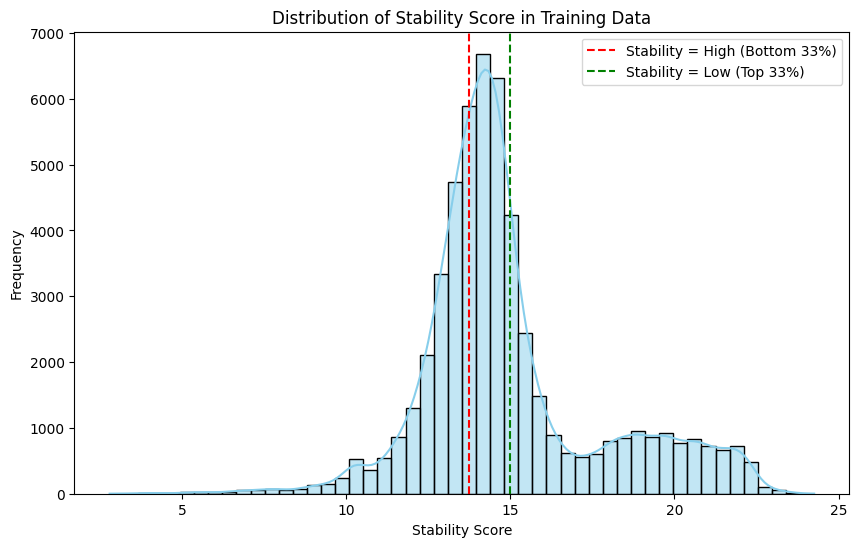

Number of samples in 'Stability = High' (Bottom 33%): 17573
Number of samples in 'Stability = Low' (Top 33%): 17573
Number of samples in the middle bucket: 18106


In [25]:
import matplotlib.pyplot as plt

# Define the percentile threshold
percentile_threshold = 0.33

# Plot the distribution of stability_score for train_df
plt.figure(figsize=(10, 6))
sns.histplot(train_df['stability_score'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Stability Score in Training Data')
plt.xlabel('Stability Score')
plt.ylabel('Frequency')

# Calculate percentiles
low_threshold = train_df['stability_score'].quantile(percentile_threshold)
high_threshold = train_df['stability_score'].quantile(1 - percentile_threshold)

# Plot lines for top 15% and bottom 15% percentiles
plt.axvline(low_threshold, color='red', linestyle='--', label=f'Stability = High (Bottom {percentile_threshold*100:.0f}%)')
plt.axvline(high_threshold, color='green', linestyle='--', label=f'Stability = Low (Top {percentile_threshold*100:.0f}%)')

# Add legend
plt.legend()

# Show plot
plt.show()

# Calculate and print the number of samples in each bucket
low_count = train_df[train_df['stability_score'] <= low_threshold].shape[0]
high_count = train_df[train_df['stability_score'] >= high_threshold].shape[0]
middle_count = train_df[(train_df['stability_score'] > low_threshold) & (train_df['stability_score'] < high_threshold)].shape[0]

print(f"Number of samples in 'Stability = High' (Bottom {percentile_threshold*100:.0f}%): {low_count}")
print(f"Number of samples in 'Stability = Low' (Top {percentile_threshold*100:.0f}%): {high_count}")
print(f"Number of samples in the middle bucket: {middle_count}")


In [ ]:
from huggingface_hub import HfApi, create_repo

# Initialize the HfApi
api = HfApi()

# Define the paths to the checkpoints and the repository details
checkpoint_paths = [
    "checkpoints_iteration0_brenda_sft_only_high_stability_ablation/epoch=4-val_loss=0.49.ckpt"
]
repo_id = "joetey/ablation_sft_exp1"

# Create the repository on the Hugging Face Hub
create_repo(repo_id, repo_type="model", exist_ok=True)

# Upload the checkpoints to the newly created repository
for checkpoint_path in checkpoint_paths:
    checkpoint_name = checkpoint_path.split('/')[-1]
    api.upload_file(
        path_or_fileobj=checkpoint_path,
        path_in_repo=checkpoint_name,
        repo_id=repo_id,
        repo_type="model"
    )


/home/joetey/prot-rl/dpo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
